In [1]:
!pip install grad-cam

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
# ============================================================
# 1. CONFIG & DEVICE
# ============================================================
DATA_ROOT = "dataset"
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
NUM_WORKERS = 8
IMG_SIZE = 224
NUM_CLASSES = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
# ============================================================
# 2. DATA LOADING
# ============================================================
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Class names from folder structure
label_names = train_dataset.classes
print(f"Classes: {label_names}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Classes: ['Cool', 'Neutral', 'Very_Cool', 'Very_Warm', 'Warm']
Train: 5400, Val: 1540, Test: 780


In [5]:
# ============================================================
# 3. CUSTOM CNN MODEL
# ============================================================
class IlluminantCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(IlluminantCNN, self).__init__()

        # Conv Block 1: Conv(32, 10x10) -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Block 2: Conv(64, 7x7) -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Block 3: Conv(96, 5x5) -> BN -> ReLU
        self.conv3 = nn.Conv2d(64, 96, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(96)

        # Conv Block 4: Conv(128, 5x5) -> BN -> ReLU
        self.conv4 = nn.Conv2d(96, 128, kernel_size=5)
        self.bn4 = nn.BatchNorm2d(128)

        # Conv Block 5: Conv(256, 3x3) -> BN -> ReLU
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(256)

        # Global Max Pooling
        self.global_pool = nn.AdaptiveMaxPool2d(1)

        # Fully Connected
        self.fc1 = nn.Linear(256, 1024)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Block 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Block 3
        x = self.relu(self.bn3(self.conv3(x)))

        # Block 4
        x = self.relu(self.bn4(self.conv4(x)))

        # Block 5
        x = self.relu(self.bn5(self.conv5(x)))

        # Global pooling + FC
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = IlluminantCNN(num_classes=NUM_CLASSES).to(device)
print(model)

IlluminantCNN(
  (conv1): Conv2d(3, 32, kernel_size=(10, 10), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveMaxPool2d(output_size=1)
  (fc1)

In [6]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 1,135,685
Trainable parameters: 1,135,685


In [7]:
# ============================================================
# 4. LOSS, OPTIMIZER, SCHEDULER
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=4,
    min_lr=5e-12
)

In [ ]:
# ============================================================
# 5. TRAINING LOOP
# ============================================================
best_val_acc = 0.0
best_model_path = "best_illuminant_cnn.pth"
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({"loss": loss.item(), "acc": correct/total})

    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

print("\n" + "="*60)
print("TRAINING")
print("="*60)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> Saved best model (val_acc: {val_acc:.4f})")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history["train_loss"], label="Train")
ax1.plot(history["val_loss"], label="Val")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Curves")
ax1.legend()

ax2.plot(history["train_acc"], label="Train")
ax2.plot(history["val_acc"], label="Val")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy Curves")
ax2.legend()

plt.tight_layout()
plt.savefig("visualizations/training_curves.png", dpi=150)
plt.show()


TEST SET EVALUATION


Testing: 100%|██████████| 4/4 [01:10<00:00, 17.71s/it]



Classification Report:
              precision    recall  f1-score   support

        Cool       0.85      0.82      0.84       156
     Neutral       0.77      0.87      0.82       156
   Very_Cool       0.85      0.78      0.81       156
   Very_Warm       0.86      0.96      0.91       156
        Warm       0.91      0.80      0.85       156

    accuracy                           0.84       780
   macro avg       0.85      0.84      0.84       780
weighted avg       0.85      0.84      0.84       780



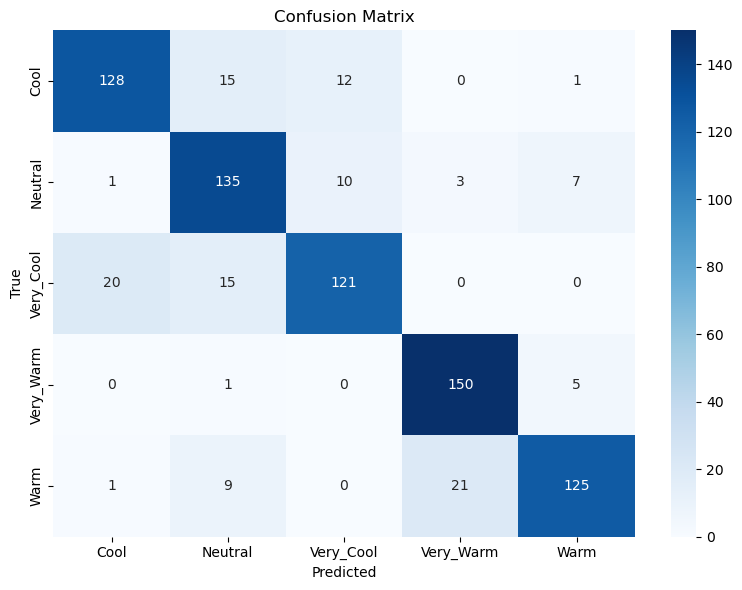


Test Accuracy: 0.8449


In [8]:
best_model_path = "best_illuminant_cnn_val_8084.pth"
# ============================================================
# 6. EVALUATION ON TEST SET
# ============================================================
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("visualizations/confusion_matrix.png", dpi=150)
plt.show()

test_acc = (all_preds == all_labels).mean()
print(f"\nTest Accuracy: {test_acc:.4f}")


GENERATING GRAD-CAM HEATMAPS
Selected 5 examples (one from each class)
Saved 5 Grad-CAM visualizations (with all 5 classes) to gradcam_heatmaps


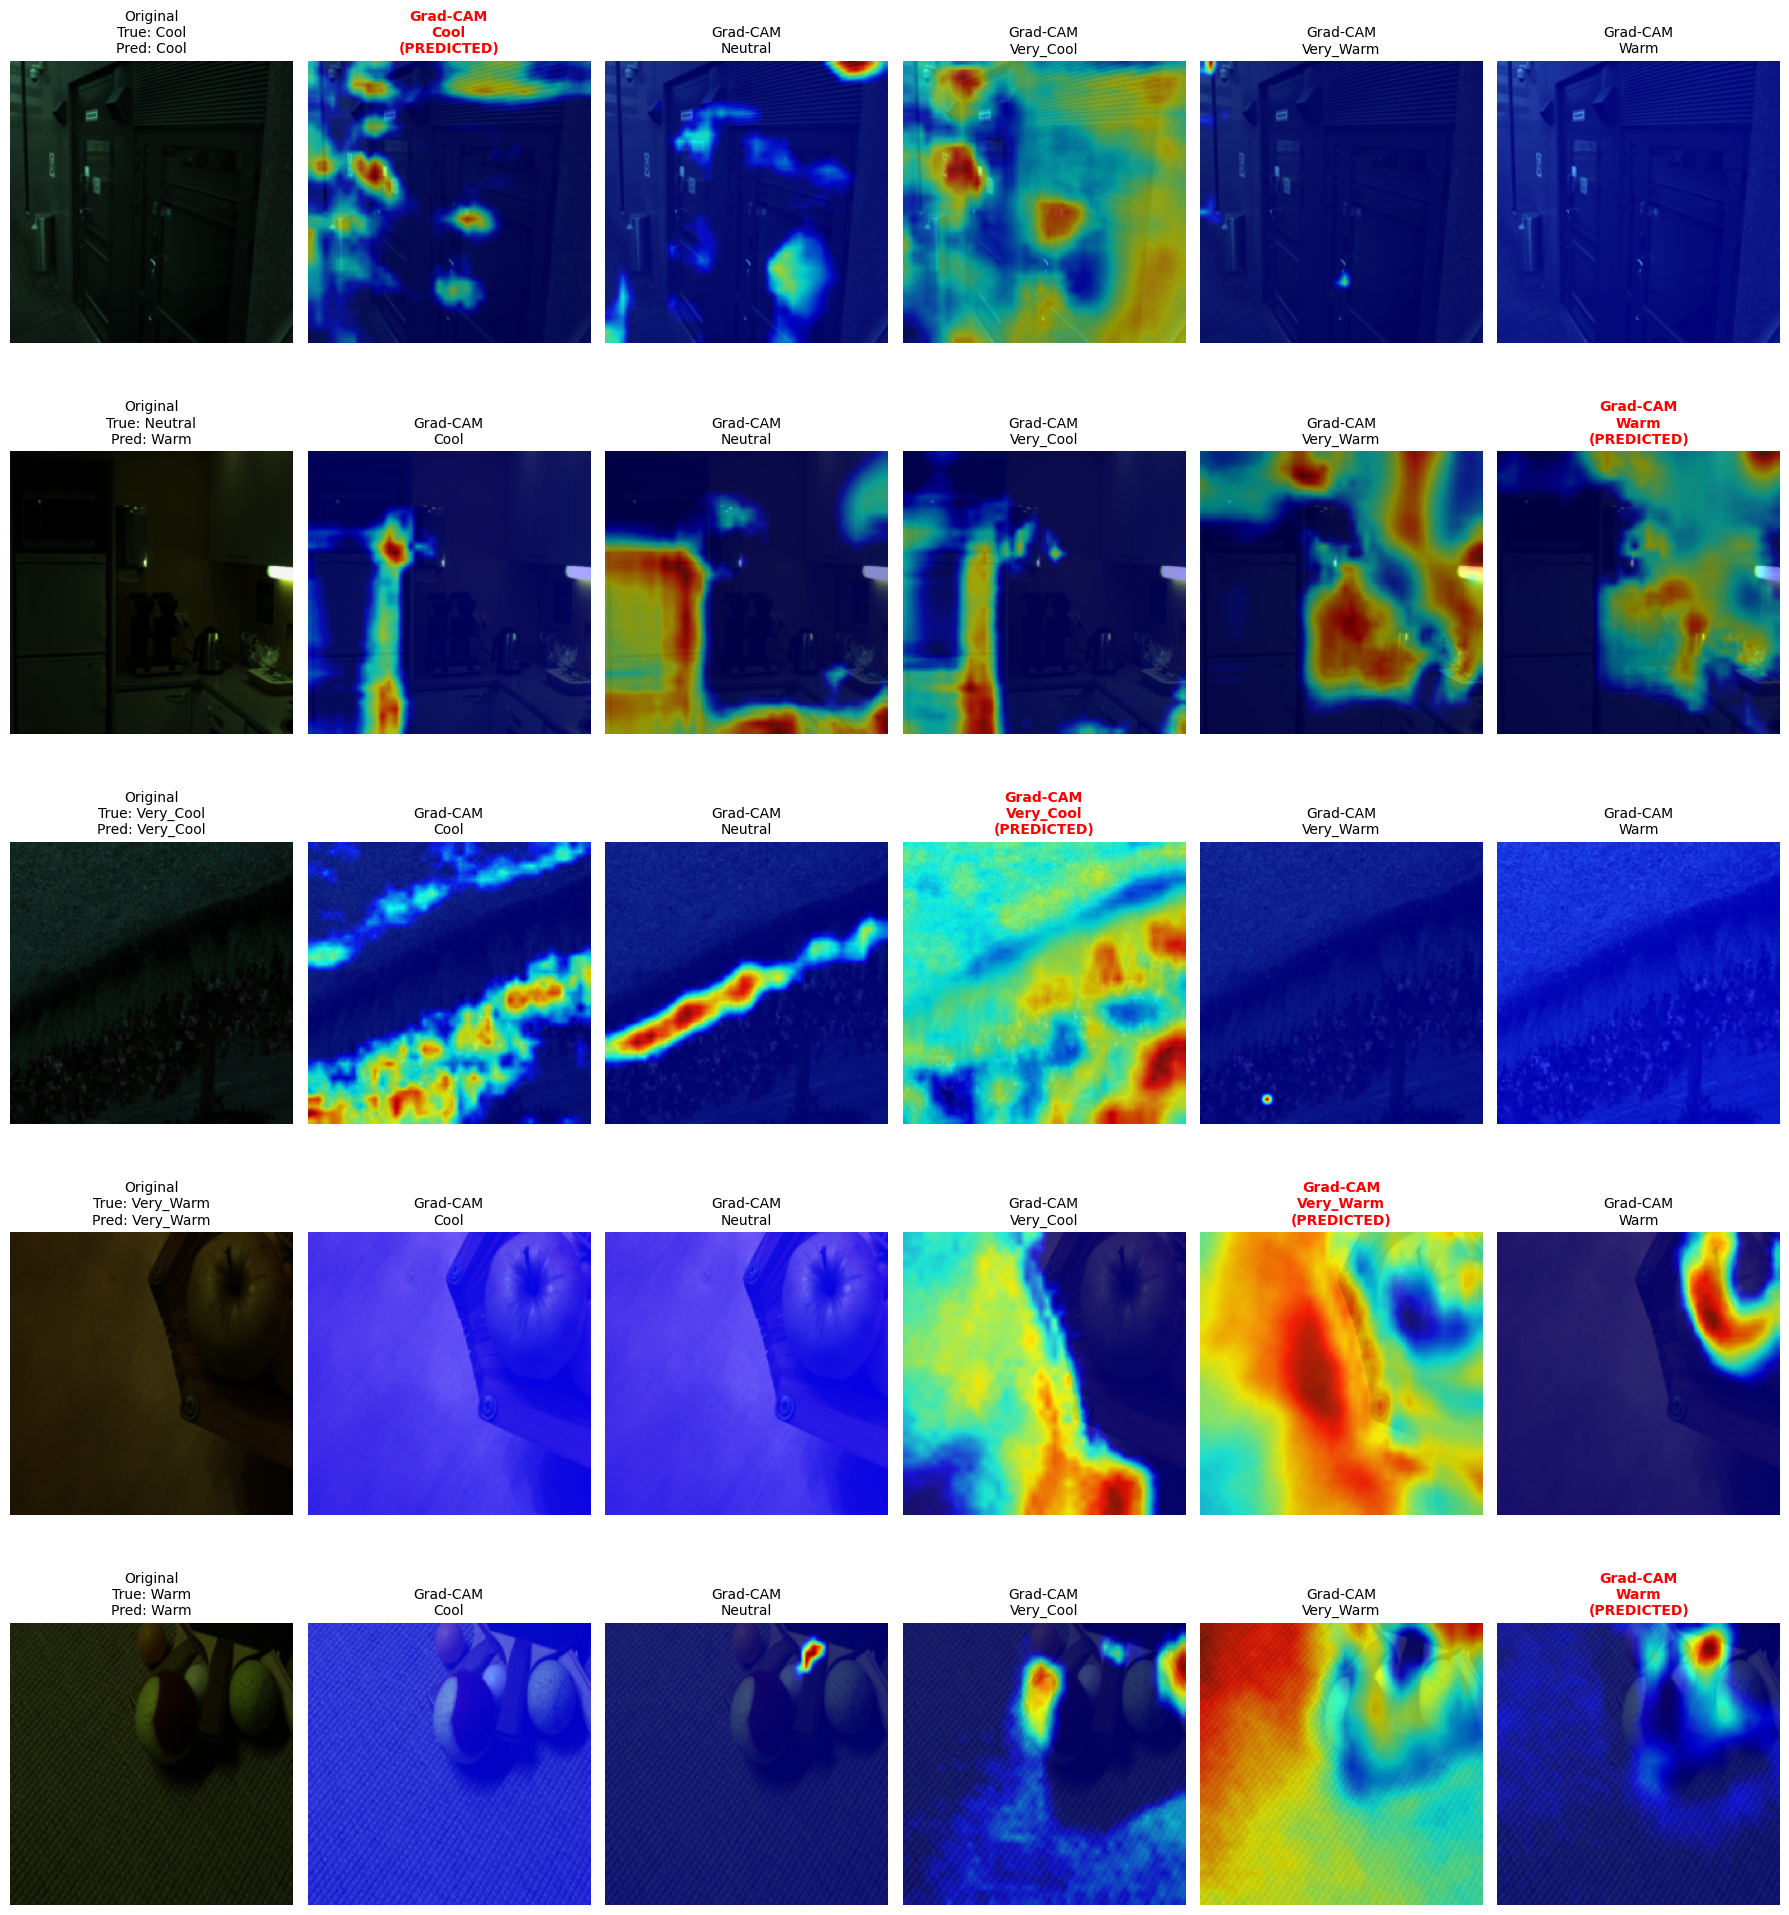

In [9]:
# ============================================================
# 7. GRAD-CAM HEATMAPS
# ============================================================
print("\n" + "="*60)
print("GENERATING GRAD-CAM HEATMAPS")
print("="*60)

def tensor_to_rgb(img_tensor, mean, std):
    """Convert normalized tensor to RGB [0,1] for visualization."""
    img_np = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0.0, 1.0)
    return img_np.astype(np.float32)

mean_np = np.array(mean, dtype=np.float32)
std_np = np.array(std, dtype=np.float32)

# Target layer: last conv layer (conv5)
target_layers = [model.conv5]

cam = GradCAM(model=model, target_layers=target_layers)

save_dir = "gradcam_heatmaps"
os.makedirs(save_dir, exist_ok=True)

# Collect one example from each of the 5 classes
examples_per_class = 1  # Number of examples per class
examples = {class_idx: [] for class_idx in range(NUM_CLASSES)}

model.eval()

# First, collect examples from all classes
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            true_label = int(labels[i].item())
            
            # Collect examples for each class (we'll randomly select later)
            if len(examples[true_label]) < examples_per_class * 10:  # Collect more than needed for random selection
                examples[true_label].append((images[i], true_label, int(preds[i].item())))
        
        # Check if we have enough examples from all classes
        if all(len(examples[class_idx]) >= examples_per_class for class_idx in range(NUM_CLASSES)):
            break

# Randomly select one example from each class
import random
random.seed(42)  # For reproducibility
selected_examples = []
for class_idx in range(NUM_CLASSES):
    if len(examples[class_idx]) > 0:
        selected = random.sample(examples[class_idx], min(examples_per_class, len(examples[class_idx])))
        selected_examples.extend(selected)

print(f"Selected {len(selected_examples)} examples (one from each class)")

# Process selected examples
processed_examples = []
for input_tensor, true_label, pred_label in selected_examples:
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    
    rgb_image = tensor_to_rgb(input_tensor[0], mean_np, std_np)
    true_name = label_names[true_label]
    pred_name = label_names[pred_label]
    
    # Generate GradCAM for all 5 classes
    overlays_all_classes = []
    for class_idx in range(NUM_CLASSES):
        targets = [ClassifierOutputTarget(class_idx)]
        
        with torch.enable_grad():
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
        
        overlay = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        overlays_all_classes.append((overlay, label_names[class_idx]))

    # Save images
    base_name = f"idx_{len(processed_examples):03d}_{true_name}"
    Image.fromarray((rgb_image * 255).astype(np.uint8)).save(
        os.path.join(save_dir, f"{base_name}_orig.png")
    )
    
    # Save GradCAM for each class
    for class_idx, (overlay, class_name) in enumerate(overlays_all_classes):
        Image.fromarray(overlay).save(
            os.path.join(save_dir, f"{base_name}_gradcam_{class_name}.png")
        )

    processed_examples.append((rgb_image, overlays_all_classes, true_name, pred_name))

print(f"Saved {len(processed_examples)} Grad-CAM visualizations (with all 5 classes) to {save_dir}")

# Plot grid: Original + 5 GradCAMs (one for each class)
rows = len(processed_examples)
if rows > 0:
    # 1 original + 5 GradCAMs = 6 columns
    fig, axes = plt.subplots(rows, 6, figsize=(18, 4 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for idx, (rgb_image, overlays_all_classes, true_name, pred_name) in enumerate(processed_examples):
        # Original image
        axes[idx, 0].imshow(rgb_image)
        axes[idx, 0].set_title(f"Original\nTrue: {true_name}\nPred: {pred_name}", fontsize=10)
        axes[idx, 0].axis("off")
        
        # GradCAM for each class
        for class_idx, (overlay, class_name) in enumerate(overlays_all_classes):
            axes[idx, class_idx + 1].imshow(overlay)
            # Highlight if this is the predicted class
            title = f"Grad-CAM\n{class_name}"
            if class_name == pred_name:
                title += "\n(PREDICTED)"
            axes[idx, class_idx + 1].set_title(title, fontsize=10, 
                                                color='red' if class_name == pred_name else 'black',
                                                weight='bold' if class_name == pred_name else 'normal')
            axes[idx, class_idx + 1].axis("off")

    plt.tight_layout()
    plt.savefig("visualizations/gradcam_grid_all_classes.png", dpi=150, bbox_inches='tight')
    plt.show()

Using device: cpu
Loaded model from: best_illuminant_cnn_val_8084.pth
Loaded cluster centers from: cluster_centers.npy
Classes: ['Cool', 'Neutral', 'Very_Cool', 'Very_Warm', 'Warm']
Test samples: 780

Cluster centers loaded:
  Cool: μ = [0.2196, 0.4427, 0.3376]
  Neutral: μ = [0.2787, 0.4658, 0.2555]
  Very_Cool: μ = [0.1941, 0.4326, 0.3733]
  Very_Warm: μ = [0.4566, 0.4139, 0.1295]
  Warm: μ = [0.3758, 0.4470, 0.1772]

RUNNING ILLUMINANT ESTIMATION ON TEST SET


Estimating: 100%|██████████| 25/25 [00:59<00:00,  2.37s/it]



ESTIMATION RESULTS

Classification Accuracy: 0.8449

Estimated Illuminants Shape: (780, 3)

Continuous Illuminant Statistics:
  R: mean=0.3072, std=0.0942, min=0.1941, max=0.4566
  G: mean=0.4404, std=0.0153, min=0.4139, max=0.4657
  B: mean=0.2524, std=0.0874, min=0.1295, max=0.3733

Per-Class Illuminant Estimates:
  Cool        : n= 156, mean=[0.2252, 0.4436, 0.3312]
  Neutral     : n= 156, mean=[0.2810, 0.4594, 0.2596]
  Very_Cool   : n= 156, mean=[0.2085, 0.4375, 0.3540]
  Very_Warm   : n= 156, mean=[0.4451, 0.4179, 0.1370]
  Warm        : n= 156, mean=[0.3763, 0.4434, 0.1803]


/var/folders/gp/jny7zmvj7k14txlpsyr_mrjr0000gn/T/ipykernel_37003/1212389704.py:312: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_box, labels=labels_for_box)


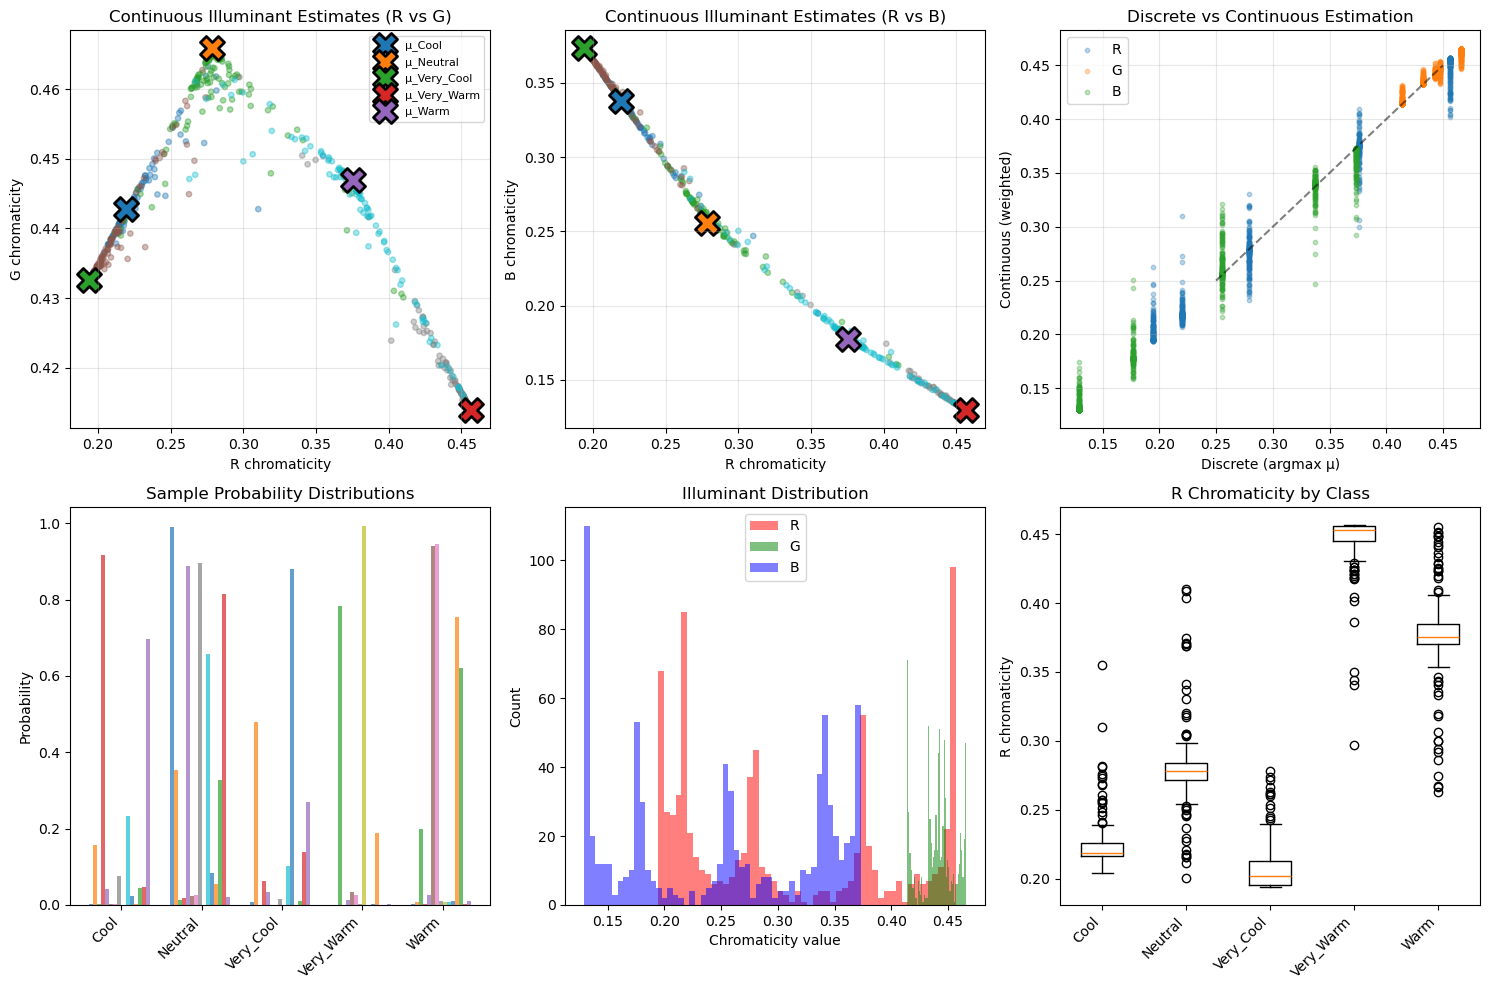


INDIVIDUAL EXAMPLES


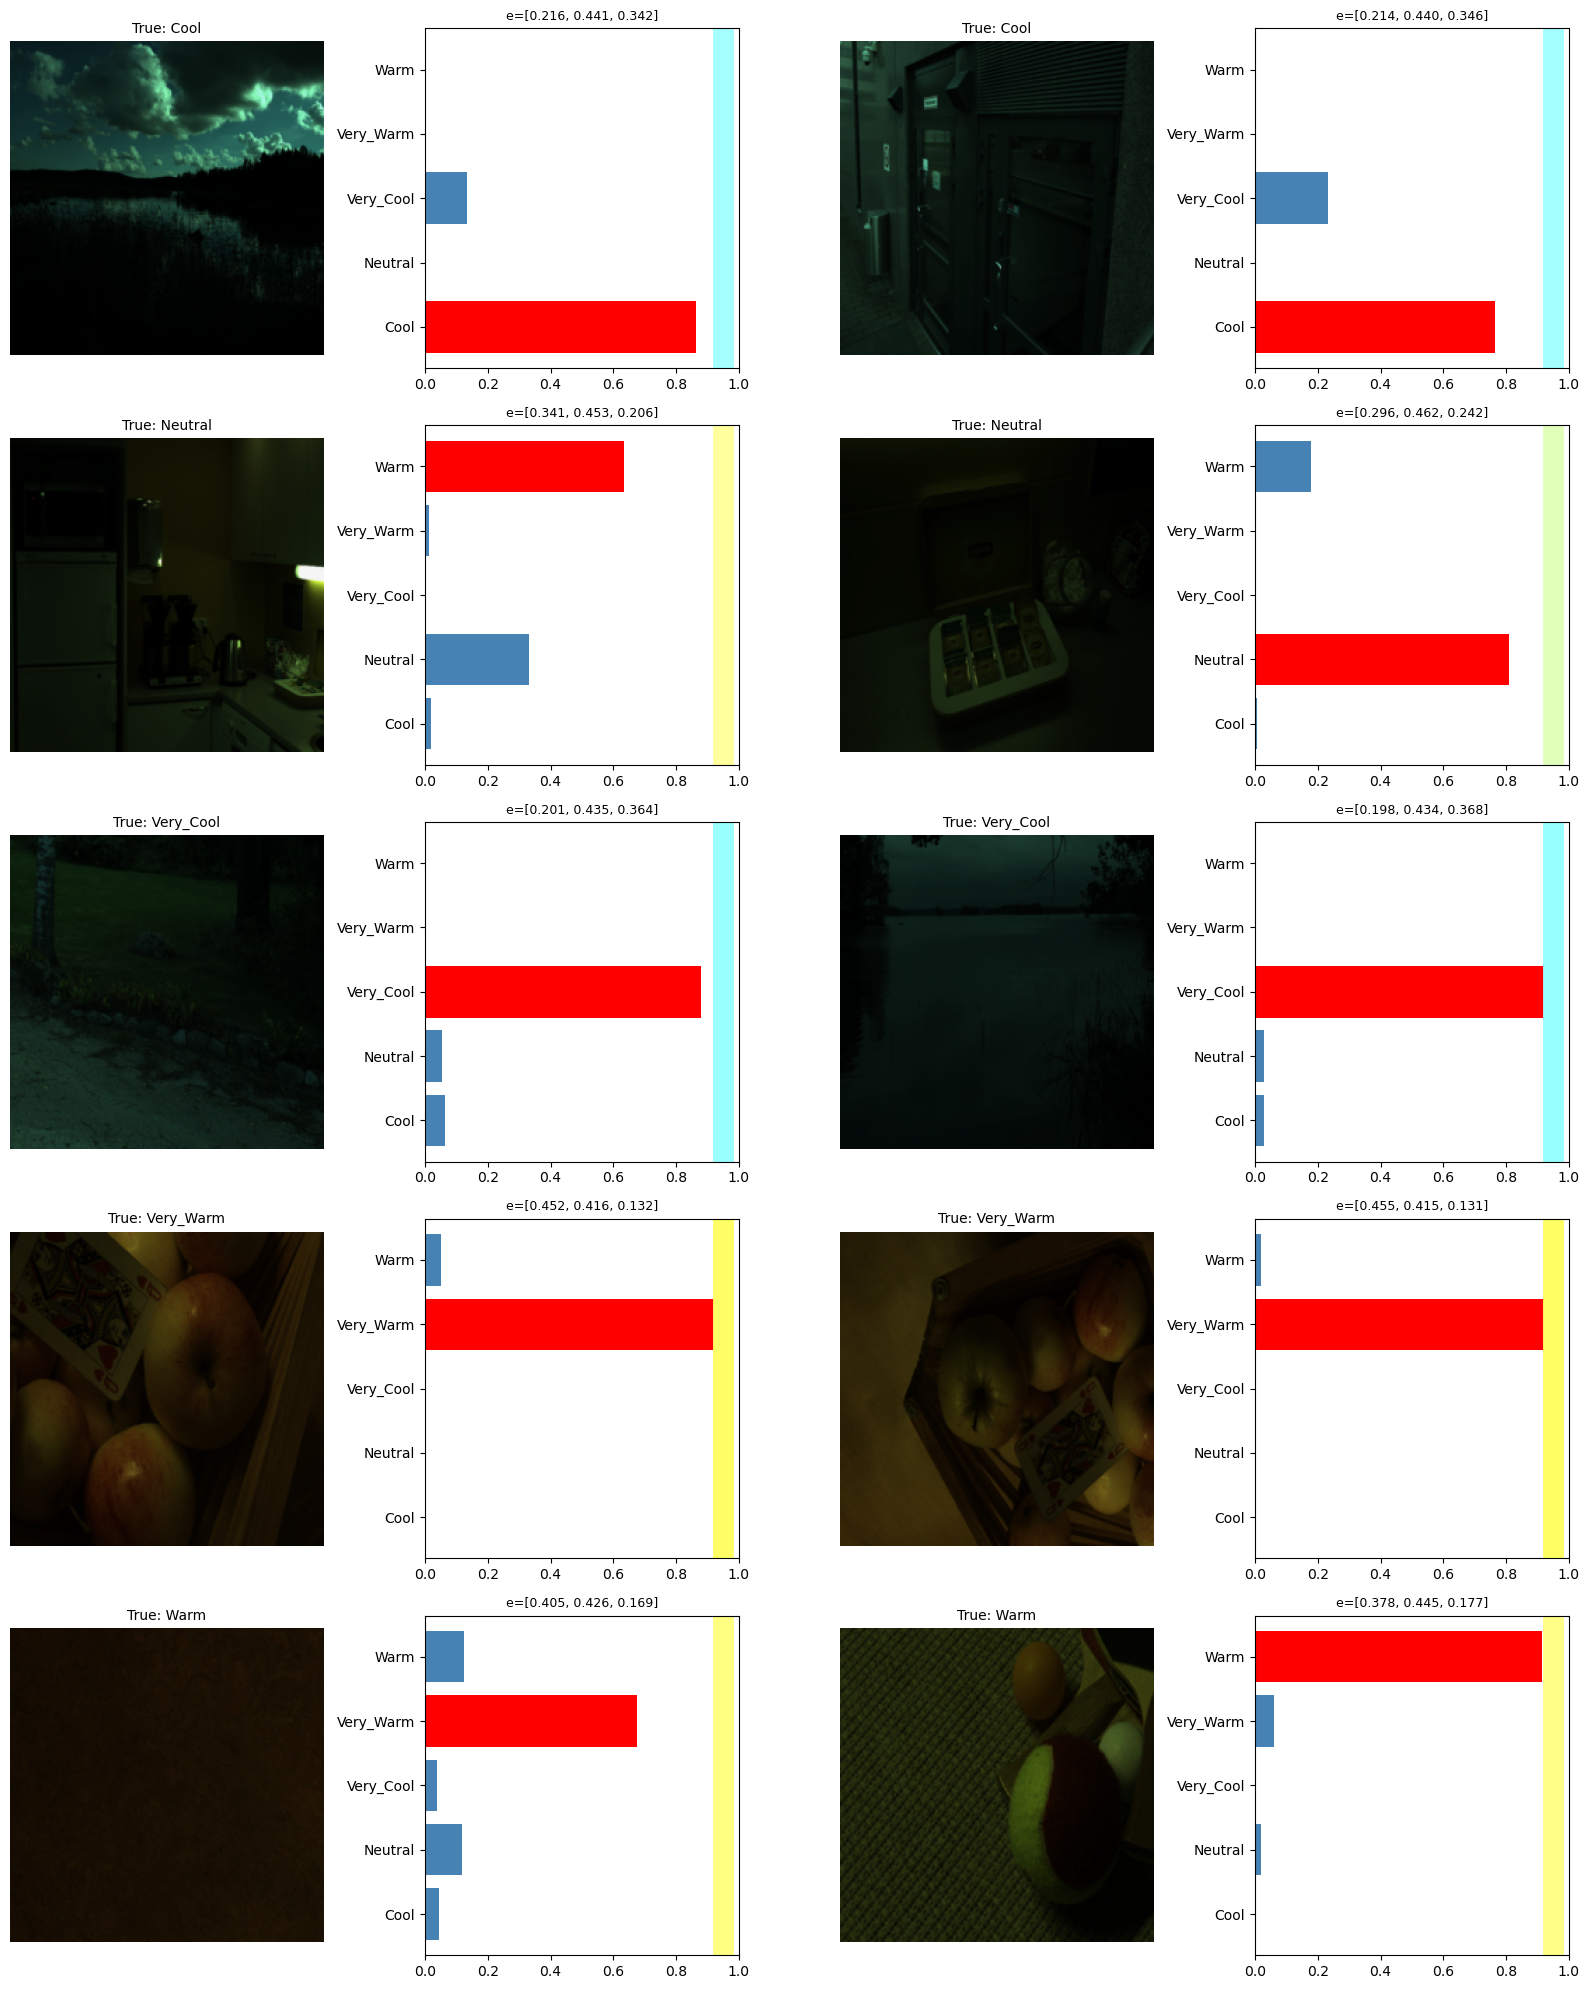


Results saved to illuminant_estimation_results.npy

DONE!

Outputs saved:
  - /content/illuminant_estimation_results.png
  - /content/illuminant_examples.png
  - /content/illuminant_estimation_results.npy

Use estimate_single_image('/path/to/image.jpg') to test individual images.


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ============================================================
# 1. CONFIG
# ============================================================
DATA_ROOT = "dataset"
MODEL_PATH = "best_illuminant_cnn_val_8084.pth"
CLUSTER_CENTERS_PATH = "cluster_centers.npy"

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 5
NUM_WORKERS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================
# 2. MODEL DEFINITION (same as training)
# ============================================================
class IlluminantCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(IlluminantCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=10)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=7)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 96, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(96)

        self.conv4 = nn.Conv2d(96, 128, kernel_size=5)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Linear(256, 1024)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ============================================================
# 3. LOAD MODEL & CLUSTER CENTERS
# ============================================================
# Load model
model = IlluminantCNN(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"Loaded model from: {MODEL_PATH}")

# Load cluster centers
cluster_centers = np.load(CLUSTER_CENTERS_PATH, allow_pickle=True).item()
print(f"Loaded cluster centers from: {CLUSTER_CENTERS_PATH}")

# ============================================================
# 4. DATA LOADING
# ============================================================
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

class_names = test_dataset.classes
print(f"Classes: {class_names}")
print(f"Test samples: {len(test_dataset)}")

# ============================================================
# 5. ILLUMINANT ESTIMATOR CLASS
# ============================================================
class IlluminantEstimator:
    """
    Estimates continuous illuminant chromaticity using:
    e = Σ(P(y=i|x) * μ_i)
    """

    def __init__(self, model, cluster_centers, class_names, device='cuda'):
        self.model = model
        self.device = device
        self.class_names = class_names
        self.K = len(class_names)

        # Build cluster center matrix [K, 3]
        self.mu = np.zeros((self.K, 3), dtype=np.float32)
        for i, name in enumerate(class_names):
            self.mu[i] = cluster_centers[name]

        self.mu_tensor = torch.from_numpy(self.mu).to(device)

        print("\nCluster centers loaded:")
        for i, name in enumerate(class_names):
            print(f"  {name}: μ = [{self.mu[i,0]:.4f}, {self.mu[i,1]:.4f}, {self.mu[i,2]:.4f}]")

    def estimate(self, image_tensor):
        """Single image estimation."""
        self.model.eval()

        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to(self.device)

        with torch.no_grad():
            logits = self.model(image_tensor)
            probs = F.softmax(logits, dim=1)

        # Weighted average: e = Σ(p_i * μ_i)
        illuminant = torch.matmul(probs, self.mu_tensor)

        return {
            'illuminant': illuminant.cpu().numpy()[0],
            'probabilities': probs.cpu().numpy()[0],
            'predicted_class': probs.argmax(dim=1).item(),
            'discrete_illuminant': self.mu[probs.argmax(dim=1).item()]
        }

    def estimate_batch(self, image_batch):
        """Batch estimation."""
        self.model.eval()
        image_batch = image_batch.to(self.device)

        with torch.no_grad():
            logits = self.model(image_batch)
            probs = F.softmax(logits, dim=1)

        illuminants = torch.matmul(probs, self.mu_tensor)
        pred_classes = probs.argmax(dim=1)
        discrete_illuminants = self.mu[pred_classes.cpu().numpy()]

        return {
            'illuminants': illuminants.cpu().numpy(),
            'probabilities': probs.cpu().numpy(),
            'predicted_classes': pred_classes.cpu().numpy(),
            'discrete_illuminants': discrete_illuminants
        }

# Initialize estimator
estimator = IlluminantEstimator(model, cluster_centers, class_names, device)

# ============================================================
# 6. RUN ESTIMATION ON TEST SET
# ============================================================
print("\n" + "="*60)
print("RUNNING ILLUMINANT ESTIMATION ON TEST SET")
print("="*60)

all_illuminants = []
all_discrete_illuminants = []
all_probs = []
all_preds = []
all_true_labels = []

for images, labels in tqdm(test_loader, desc="Estimating"):
    results = estimator.estimate_batch(images)

    all_illuminants.append(results['illuminants'])
    all_discrete_illuminants.append(results['discrete_illuminants'])
    all_probs.append(results['probabilities'])
    all_preds.append(results['predicted_classes'])
    all_true_labels.append(labels.numpy())

# Concatenate all results
all_illuminants = np.concatenate(all_illuminants, axis=0)
all_discrete_illuminants = np.concatenate(all_discrete_illuminants, axis=0)
all_probs = np.concatenate(all_probs, axis=0)
all_preds = np.concatenate(all_preds, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# ============================================================
# 7. RESULTS SUMMARY
# ============================================================
print("\n" + "="*60)
print("ESTIMATION RESULTS")
print("="*60)

accuracy = (all_preds == all_true_labels).mean()
print(f"\nClassification Accuracy: {accuracy:.4f}")

print(f"\nEstimated Illuminants Shape: {all_illuminants.shape}")
print(f"\nContinuous Illuminant Statistics:")
print(f"  R: mean={all_illuminants[:,0].mean():.4f}, std={all_illuminants[:,0].std():.4f}, "
      f"min={all_illuminants[:,0].min():.4f}, max={all_illuminants[:,0].max():.4f}")
print(f"  G: mean={all_illuminants[:,1].mean():.4f}, std={all_illuminants[:,1].std():.4f}, "
      f"min={all_illuminants[:,1].min():.4f}, max={all_illuminants[:,1].max():.4f}")
print(f"  B: mean={all_illuminants[:,2].mean():.4f}, std={all_illuminants[:,2].std():.4f}, "
      f"min={all_illuminants[:,2].min():.4f}, max={all_illuminants[:,2].max():.4f}")

# Per-class statistics
print("\nPer-Class Illuminant Estimates:")
for i, name in enumerate(class_names):
    mask = all_true_labels == i
    if mask.sum() > 0:
        class_illuminants = all_illuminants[mask]
        print(f"  {name:12s}: n={mask.sum():4d}, "
              f"mean=[{class_illuminants[:,0].mean():.4f}, "
              f"{class_illuminants[:,1].mean():.4f}, "
              f"{class_illuminants[:,2].mean():.4f}]")

# ============================================================
# 8. VISUALIZATION
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Chromaticity scatter (R vs G)
ax = axes[0, 0]
scatter_colors = plt.cm.tab10(all_true_labels / (NUM_CLASSES - 1))
ax.scatter(all_illuminants[:, 0], all_illuminants[:, 1], c=scatter_colors, alpha=0.4, s=15)
for i, name in enumerate(class_names):
    ax.scatter(estimator.mu[i, 0], estimator.mu[i, 1],
               marker='X', s=300, edgecolors='black', linewidth=2, label=f"μ_{name}")
ax.set_xlabel("R chromaticity")
ax.set_ylabel("G chromaticity")
ax.set_title("Continuous Illuminant Estimates (R vs G)")
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Chromaticity scatter (R vs B)
ax = axes[0, 1]
ax.scatter(all_illuminants[:, 0], all_illuminants[:, 2], c=scatter_colors, alpha=0.4, s=15)
for i, name in enumerate(class_names):
    ax.scatter(estimator.mu[i, 0], estimator.mu[i, 2],
               marker='X', s=300, edgecolors='black', linewidth=2)
ax.set_xlabel("R chromaticity")
ax.set_ylabel("B chromaticity")
ax.set_title("Continuous Illuminant Estimates (R vs B)")
ax.grid(True, alpha=0.3)

# Plot 3: Discrete vs Continuous comparison
ax = axes[0, 2]
ax.scatter(all_discrete_illuminants[:, 0], all_illuminants[:, 0], alpha=0.3, s=10, label='R')
ax.scatter(all_discrete_illuminants[:, 1], all_illuminants[:, 1], alpha=0.3, s=10, label='G')
ax.scatter(all_discrete_illuminants[:, 2], all_illuminants[:, 2], alpha=0.3, s=10, label='B')
lims = [0.25, 0.45]
ax.plot(lims, lims, 'k--', alpha=0.5)
ax.set_xlabel("Discrete (argmax μ)")
ax.set_ylabel("Continuous (weighted)")
ax.set_title("Discrete vs Continuous Estimation")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Probability distribution samples
ax = axes[1, 0]
sample_idx = np.random.choice(len(all_probs), min(15, len(all_probs)), replace=False)
x_pos = np.arange(NUM_CLASSES)
width = 0.05
for j, idx in enumerate(sample_idx):
    ax.bar(x_pos + j*width, all_probs[idx], width, alpha=0.7)
ax.set_xticks(x_pos + width * len(sample_idx) / 2)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylabel("Probability")
ax.set_title("Sample Probability Distributions")

# Plot 5: Illuminant distribution histograms
ax = axes[1, 1]
ax.hist(all_illuminants[:, 0], bins=50, alpha=0.5, label='R', color='red')
ax.hist(all_illuminants[:, 1], bins=50, alpha=0.5, label='G', color='green')
ax.hist(all_illuminants[:, 2], bins=50, alpha=0.5, label='B', color='blue')
ax.set_xlabel("Chromaticity value")
ax.set_ylabel("Count")
ax.set_title("Illuminant Distribution")
ax.legend()

# Plot 6: Per-class box plot
ax = axes[1, 2]
data_for_box = []
labels_for_box = []
for i, name in enumerate(class_names):
    mask = all_true_labels == i
    if mask.sum() > 0:
        # Use R chromaticity for box plot
        data_for_box.append(all_illuminants[mask, 0])
        labels_for_box.append(name)
ax.boxplot(data_for_box, labels=labels_for_box)
ax.set_ylabel("R chromaticity")
ax.set_title("R Chromaticity by Class")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("illuminant_estimation_results.png", dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 9. INDIVIDUAL EXAMPLES VISUALIZATION
# ============================================================
print("\n" + "="*60)
print("INDIVIDUAL EXAMPLES")
print("="*60)

def tensor_to_rgb(img_tensor):
    """Denormalize tensor to RGB [0,1]."""
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = np.array(std) * img_np + np.array(mean)
    return np.clip(img_np, 0.0, 1.0)

# Show examples from each class
num_examples_per_class = 2
fig, axes = plt.subplots(NUM_CLASSES, num_examples_per_class * 2,
                          figsize=(4 * num_examples_per_class * 2, 4 * NUM_CLASSES))

for class_idx, class_name in enumerate(class_names):
    # Get images from this class
    class_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == class_idx]

    for ex_idx in range(num_examples_per_class):
        if ex_idx >= len(class_indices):
            break

        img_idx = class_indices[ex_idx]
        img_tensor, true_label = test_dataset[img_idx]

        # Estimate
        result = estimator.estimate(img_tensor)

        # Original image
        ax_img = axes[class_idx, ex_idx * 2]
        rgb_img = tensor_to_rgb(img_tensor)
        ax_img.imshow(rgb_img)
        ax_img.set_title(f"True: {class_name}", fontsize=10)
        ax_img.axis('off')

        # Probability bar chart
        ax_bar = axes[class_idx, ex_idx * 2 + 1]
        colors = ['red' if i == result['predicted_class'] else 'steelblue'
                  for i in range(NUM_CLASSES)]
        ax_bar.barh(class_names, result['probabilities'], color=colors)
        ax_bar.set_xlim(0, 1)
        ax_bar.set_title(f"e=[{result['illuminant'][0]:.3f}, "
                        f"{result['illuminant'][1]:.3f}, "
                        f"{result['illuminant'][2]:.3f}]", fontsize=9)

        # Add illuminant color patch
        ill_color = np.clip(result['illuminant'] * 3, 0, 1)  # Scale for visibility
        ax_bar.axvline(x=0.95, color=ill_color, linewidth=15)

plt.tight_layout()
plt.savefig("illuminant_examples.png", dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 10. SAVE RESULTS
# ============================================================
results_dict = {
    'illuminants': all_illuminants,
    'discrete_illuminants': all_discrete_illuminants,
    'probabilities': all_probs,
    'predicted_classes': all_preds,
    'true_labels': all_true_labels,
    'class_names': class_names,
    'cluster_centers': estimator.mu
}

np.save("illuminant_estimation_results.npy", results_dict)
print("\nResults saved to illuminant_estimation_results.npy")

# ============================================================
# 11. QUICK ACCESS FUNCTION FOR SINGLE IMAGE
# ============================================================
def estimate_single_image(image_path):
    """
    Convenience function to estimate illuminant for any image path.
    """
    img = Image.open(image_path).convert('RGB')
    img_tensor = test_transform(img)

    result = estimator.estimate(img_tensor)

    print(f"\nImage: {image_path}")
    print(f"Predicted class: {class_names[result['predicted_class']]}")
    print(f"Confidence: {result['probabilities'][result['predicted_class']]:.4f}")
    print(f"\nClass probabilities:")
    for i, name in enumerate(class_names):
        print(f"  {name}: {result['probabilities'][i]:.4f}")
    print(f"\nEstimated illuminant (continuous): "
          f"[{result['illuminant'][0]:.4f}, {result['illuminant'][1]:.4f}, {result['illuminant'][2]:.4f}]")
    print(f"Discrete illuminant (argmax):     "
          f"[{result['discrete_illuminant'][0]:.4f}, {result['discrete_illuminant'][1]:.4f}, {result['discrete_illuminant'][2]:.4f}]")

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[result['predicted_class']]}\n"
              f"Illuminant: [{result['illuminant'][0]:.3f}, {result['illuminant'][1]:.3f}, {result['illuminant'][2]:.3f}]")
    plt.axis('off')
    plt.show()

    return result

# Example usage:
# result = estimate_single_image("/content/dataset/test/Warm/some_image.jpg")

print("\n" + "="*60)
print("DONE!")
print("="*60)
print("\nOutputs saved:")
print("  - /content/illuminant_estimation_results.png")
print("  - /content/illuminant_examples.png")
print("  - /content/illuminant_estimation_results.npy")
print("\nUse estimate_single_image('/path/to/image.jpg') to test individual images.")